# Configuration Step

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ViennaRNA
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.8 MB/s eta 0:00:00


In [3]:
import os
from Bio import SeqIO
import RNA
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from gensim.models import Word2Vec, KeyedVectors
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import seaborn as sns
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Load arrays
path = "/content/drive/MyDrive/maestria/tesis"
X_train = np.load(f"{path}/X_train.npy")
X_test = np.load(f"{path}/X_test.npy")
y_train = np.load(f"{path}/y_train.npy")
y_test = np.load(f"{path}/y_test.npy")
sequence_for_screening = str(np.load(f"{path}/sequence_for_screening.npy"))
sequence_for_screening_only_negatives = str(np.load(f"{path}/sequence_for_screening_only_negatives.npy"))
chromosome_path = f"{path}/chromosome1.fa"
invalid_data_path = f"{path}/invalid_data.fa"
chr_with_mirna = f"{path}/chr1_with_mirna.fa"
neg_seq_chr1_1_path = f"{path}/negative_sequence_1.fa"

In [5]:
SCREEN_SIZE = 84

# Methods

In [6]:
def convert_RNA_sequence_to_DNA(sequence):
    return sequence.replace('U', 'T')

def convert_DNA_sequence_to_RNA(sequence):
    return sequence.replace('T', 'U')

def get_histogram(sequence):
    """Obtiene el histograma de una secuencia de ARN."""
    return Counter(sequence)

def generate_random_sequence_with_histogram(histogram):
    """Genera una secuencia aleatoria con el mismo histograma que la secuencia original."""
    # Expand the histogram into a list of nucleotides
    nucleotides = []
    for nucleotide, count in histogram.items():
        nucleotides.extend([nucleotide] * count)

    # Shuffle the list to create a random sequence
    random.shuffle(nucleotides)

    # Convert the list back to a string (sequence)
    return ''.join(nucleotides)

def get_results_of_screening_with_word2vec(sequence_for_screening, screen_size=SCREEN_SIZE):
    results_mirna = []
    start = time.time()
    for idx in range(0, len(sequence_for_screening)-screen_size):
        new_sequence = sequence_for_screening[idx:idx+screen_size]
        new_embedding = miRNA2Vec.get_average_embeddings([new_sequence])
        new_prediction = svm_model.predict_proba(new_embedding)
        results_mirna.append(new_prediction[0][1])
    end = time.time()
    print(f"time: {end-start} seconds")
    return results_mirna

def get_results_of_screening_with_word2vec_and_nb(sequence_for_screening, screen_size=SCREEN_SIZE):
    results_mirna = []
    start = time.time()
    for idx in range(0, len(sequence_for_screening)-screen_size):
        new_sequence = sequence_for_screening[idx:idx+screen_size]
        new_embedding = miRNA2Vec.get_average_embeddings([new_sequence])
        new_prediction = nb_model.predict_proba(new_embedding)
        results_mirna.append(new_prediction[0][1])
    end = time.time()
    print(f"time: {end-start} seconds")
    return results_mirna

def get_results_of_screening_with_word2vec_and_rf(sequence_for_screening, screen_size=SCREEN_SIZE):
    results_mirna = []
    start = time.time()
    for idx in range(0, len(sequence_for_screening)-screen_size):
        new_sequence = sequence_for_screening[idx:idx+screen_size]
        new_embedding = miRNA2Vec.get_average_embeddings([new_sequence])
        new_prediction = rf_model.predict_proba(new_embedding)
        results_mirna.append(new_prediction[0][1])
    end = time.time()
    print(f"time: {end-start} seconds")
    return results_mirna

def get_complementary_sequence(sequences):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return [''.join(complement[base] for base in seq) for seq in sequences]


# Fasta Manager

In [7]:
class FastaManager:
    FASTA = "fasta"
    FA = "fa"

    @staticmethod
    def read_fasta(file_path):
        """Read sequences from a FASTA file."""
        sequences = []
        with open(file_path, "r") as file:
            for record in SeqIO.parse(file, FastaManager.FASTA):
                sequences.append(str(record.seq))
        return sequences

    @staticmethod
    def get_all_sequences(input_dir):
        """Read FASTA files from input_dir and return sequences."""
        all_sequences = []
        for file_name in os.listdir(input_dir):
            if file_name.endswith(f".{FastaManager.FASTA}") or file_name.endswith(f".{FastaManager.FA}"):
                file_path = os.path.join(input_dir, file_name)
                sequences = FastaManager.read_fasta(file_path)
                all_sequences.extend(sequences)
        return all_sequences

    @staticmethod
    def create_fasta_dataset(input_dir, embedding):
        """Read FASTA files from input_dir and return tokenized sequences."""
        return embedding.tokenize_sequences(FastaManager.get_all_sequences(input_dir))

    @staticmethod
    def create_dataset(sequences, embedding):
        """Read list of sequences and return tokenized sequences."""
        return embedding.tokenize_sequences(sequences)

# Generate dataset

## Getting positive samples

In [29]:
df = pd.read_csv(f'{path}/dataset_DNA_chr1.csv')
df.head()

,pos_inicial,pos_final,secuencia,chromosome
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1


In [9]:
#df.drop(df.tail(1).index,inplace=True)

In [30]:
df = df.loc[~df['secuencia'].str.contains('N')]
df

,pos_inicial,pos_final,secuencia,chromosome
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1
...,...,...,...,...
500,102539644,102539726,GAGGCCTGTGTGCCTGTCAAATAGCTACAGTTAAGAAATCTTCACA...,NaN
501,26908642,26908725,TCCAACTCCCAGCTCAAGTGATCCTCCCACTTCAGCCTCTCGAGTG...,NaN
502,54878113,54878193,GCAAAAGGCGTCCTTGGGAATTCAACTGAGTACTAATCGGTAAATA...,NaN
503,47760995,47761104,CCTCCACATGCTTTCAATCCCATGGCAGCCTGTGGGTCCTGGGAAG...,NaN


In [31]:
df = df.drop_duplicates(subset='secuencia')
df

,pos_inicial,pos_final,secuencia,chromosome
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1
...,...,...,...,...
500,102539644,102539726,GAGGCCTGTGTGCCTGTCAAATAGCTACAGTTAAGAAATCTTCACA...,NaN
501,26908642,26908725,TCCAACTCCCAGCTCAAGTGATCCTCCCACTTCAGCCTCTCGAGTG...,NaN
502,54878113,54878193,GCAAAAGGCGTCCTTGGGAATTCAACTGAGTACTAATCGGTAAATA...,NaN
503,47760995,47761104,CCTCCACATGCTTTCAATCCCATGGCAGCCTGTGGGTCCTGGGAAG...,NaN


In [32]:
df['secuencia'] = df['secuencia'].str.replace('\n', '')
positive_sequences = df['secuencia'].to_list()

<ipython-input-32-5415f45b2c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secuencia'] = df['secuencia'].str.replace('\n', '')


## Getting negative samples

In [43]:
negative_sequences = []

In [42]:
negative_sequences = FastaManager.read_fasta(f"{path}/pseudo_hairpin_human.fasta")[:1792]
negative_sequences = [convert_RNA_sequence_to_DNA(seq) for seq in negative_sequences]
len(negative_sequences)

1792

### Getting data from chromosome

In [44]:
negative_sequence = FastaManager.read_fasta(chr_with_mirna)[0][5000:10000]
substring_length = 100
substrings = []
for idx in range(0, len(negative_sequence)-substring_length, int(substring_length / 12)):
        new_sequence = negative_sequence[idx:idx+substring_length]
        substrings.append(new_sequence)
#substrings = [negative_sequence[i:i+substring_length] for i in range(0, len(negative_sequence) - substring_length + 1, substring_length)]
negative_sequences.extend(substrings)
len(negative_sequences)

613

In [45]:
negative_sequence = FastaManager.read_fasta(neg_seq_chr1_1_path)[0][:10000]
substring_length = 100
substrings = []
for idx in range(0, len(negative_sequence)-substring_length, int(substring_length / 12)):
        new_sequence = negative_sequence[idx:idx+substring_length]
        substrings.append(new_sequence)
#substrings = [negative_sequence[i:i+substring_length] for i in range(0, len(negative_sequence) - substring_length + 1, substring_length)]
negative_sequences.extend(substrings)
len(negative_sequences)

1851

## Data Augmentation

In [34]:
positive_sequences.extend([s[::-1] for s in positive_sequences])

In [35]:
len(positive_sequences)

996

In [36]:
positive_sequences.extend(get_complementary_sequence(positive_sequences))

In [37]:
len(positive_sequences)

1992

## Distribute data

In [47]:
y_positive = np.ones(len(positive_sequences))
y_negative = np.zeros(len(negative_sequences))

X = positive_sequences + negative_sequences
y = np.append(y_positive, y_negative)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Screening

In [22]:
class Screening:

    def __init__(self, positive_sequences=None, negative_sequences=None):
        self.list_of_positions_of_positive_samples = []
        self.positive_sequences = positive_sequences
        self.negative_sequences = negative_sequences
        self.positive_map = {0: []}
        self.negative_map = {}
        for seq in positive_sequences:
            if self.positive_map.get(len(seq)):
                self.positive_map[len(seq)].append(seq)
            else:
                self.positive_map[len(seq)] = []
                self.positive_map[len(seq)].append(seq)
        for seq in negative_sequences:
            if self.negative_map.get(len(seq)):
                self.negative_map[len(seq)].append(seq)
            else:
                self.negative_map[len(seq)] = []
                self.negative_map[len(seq)].append(seq)
        self.nt_with_most_data = 0
        for nt in self.positive_map.keys():
            if len(self.positive_map[nt]) > len(self.positive_map[self.nt_with_most_data]):
                self.nt_with_most_data = nt

    def get_sequence_for_screening(self, nt=None, k=None):
        self.list_of_positions_of_positive_samples = []
        if not nt:
            nt = self.nt_with_most_data
        sequence = ""
        positive_samples = self.positive_map.get(nt)
        if not positive_samples:
            return sequence
        k = int(len(self.negative_sequences) / len(positive_samples)) if not k else k
        for idx, pos_sample in enumerate(positive_samples):
            sequence += ''.join(self.negative_sequences[idx * k: idx * k + k])
            self.list_of_positions_of_positive_samples.append(len(sequence))
            sequence += pos_sample
        # check if there is missing negative sample to extend to the end of total sequence
        if (len(positive_samples) - 1) * k < len(self.negative_sequences):
            sequence + ''.join(self.negative_sequences[(len(positive_samples) - 1) * k:-1])

        return ''.join(sequence)

    def get_map_nt_number_of_sequence(self):
        map_to_return = {}
        for nt in self.positive_map.keys():
            map_to_return[nt] = len(self.positive_map.get(nt))
        return map_to_return



# miRNA2Vec

In [23]:
class MiRNA2Vec:
    def __init__(self, k_mers: int = 3, vector_size: int = 100, epochs: int = 5):
        self.__model = None
        self.k_mers = k_mers
        self.vector_size = vector_size
        self.epochs = epochs
        self.window = 5
        self.min_count = 1
        self.workers = 4
        self.skip_gram = 1

    @property
    def model(self):
        return self.__model

    def __get_tokens(self, sequence):
        return [sequence[i:i + self.k_mers] for i in range(len(sequence) - self.k_mers + 1)]

    def tokenize_sequences(self, sequences):
        """Tokenize sequences into k-mers."""
        tokenized_sequences = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            tokenized_sequences.append(tokens)
        return tokenized_sequences

    def train_word2vec(self, tokenized_sequences):
        """Train Word2Vec model on tokenized sequences."""
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs,
                                sg=self.skip_gram)
        return self.__model

    def get_average_embeddings(self, sequences):
        """Get average embedding for each sequence."""
        embeddings = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            token_embeddings = [self.model.wv[token] for token in tokens if token in self.model.wv]
            if token_embeddings:
                avg_embedding = np.mean(token_embeddings, axis=0)
            else:
                avg_embedding = np.zeros(self.model.vector_size)
            embeddings.append(avg_embedding.tolist())
        return np.array(embeddings)

    def load_model(self, path, tokenized_sequences):
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs)
        self.__model.wv = KeyedVectors.load_word2vec_format(path,
                                          binary=False)  # Change binary to False if the model is in text format
        # Continue training the Word2Vec model with your new sequences
        self.__model.build_vocab(tokenized_sequences, update=True)  # Update the vocabulary with new sentences
        self.__model.train(tokenized_sequences, total_examples=self.__model.corpus_count, epochs=self.__model.epochs)
        return self.__model


## Tunning

### miRNA2Vec

In [45]:
# Supón que tienes una función para evaluar el modelo (defínela según tu necesidad).
def evaluate_model(miRNA2Vec):
    X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
    X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
    # Train SVM
    svm_model = SVC(kernel='rbf', class_weight="balanced", C=1.5, probability=True)
    svm_model.fit(X_train_mirna2vec, y_train)
    # Predict and evaluate
    y_pred = svm_model.predict(X_test_mirna2vec)
    return f1_score(y_test, y_pred)

# Definir el rango de hiperparámetros a probar
param_grid = {
    'k_mers': [3, 4, 5],
    'vector_size': [8, 16, 32],
    'epochs': [5, 10, 50]
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")
    miRNA2Vec = MiRNA2Vec(k_mers=params['k_mers'], vector_size=params['vector_size'], epochs=params['epochs'])
    tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
    miRNA2Vec.train_word2vec(tokenized_sequences)

    # Evalúa el modelo
    score = evaluate_model(miRNA2Vec)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")

# Entrena el mejor modelo con los mejores hiperparámetros
best_miRNA2Vec = MiRNA2Vec(k_mers=best_params['k_mers'], vector_size=best_params['vector_size'], epochs=best_params['epochs'])
best_miRNA2Vec.train_word2vec(tokenized_sequences)

Probando con hiperparámetros: {'epochs': 5, 'k_mers': 3, 'vector_size': 8}
Score: 0.6741573033707865
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 3, 'vector_size': 16}
Score: 0.7195767195767195
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 3, 'vector_size': 32}
Score: 0.7243243243243244
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 4, 'vector_size': 8}
Score: 0.625
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 4, 'vector_size': 16}
Score: 0.6303030303030303
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 4, 'vector_size': 32}
Score: 0.6777777777777778
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 5, 'vector_size': 8}
Score: 0.6086956521739131
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 5, 'vector_size': 16}
Score: 0.6588235294117647
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 5, 'vector_size': 32}
Score: 0.6432748538011696
Probando con hiperparámetros: {'epochs': 10, 'k_mers': 3, 'vector_size': 8}
Score: 0.6888888888888

### SVC

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', None],
    'c': [0.25, 0.5, 1, 1.5]
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)

for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")
    # Train SVM
    svm_model = SVC(kernel=params['kernel'], class_weight=params['class_weight'], C=params['c'], probability=True)
    svm_model.fit(X_train_mirna2vec, y_train)
    # Predict and evaluate
    y_pred = svm_model.predict(X_test_mirna2vec)
    # Evalúa el modelo
    score = f1_score(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")

Probando con hiperparámetros: {'c': 0.25, 'class_weight': 'balanced', 'kernel': 'rbf'}
Score: 0.7927461139896373
Probando con hiperparámetros: {'c': 0.25, 'class_weight': 'balanced', 'kernel': 'poly'}
Score: 0.7932379713914174
Probando con hiperparámetros: {'c': 0.25, 'class_weight': None, 'kernel': 'rbf'}
Score: 0.8010204081632653
Probando con hiperparámetros: {'c': 0.25, 'class_weight': None, 'kernel': 'poly'}
Score: 0.7912932138284251
Probando con hiperparámetros: {'c': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Score: 0.7942708333333334
Probando con hiperparámetros: {'c': 0.5, 'class_weight': 'balanced', 'kernel': 'poly'}
Score: 0.7885117493472585
Probando con hiperparámetros: {'c': 0.5, 'class_weight': None, 'kernel': 'rbf'}
Score: 0.8061224489795918
Probando con hiperparámetros: {'c': 0.5, 'class_weight': None, 'kernel': 'poly'}
Score: 0.8
Probando con hiperparámetros: {'c': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Score: 0.7974025974025974
Probando con hiperparámet

### Naive Bayes

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=20)
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Train Naive Bayes
    nb_model = GaussianNB(var_smoothing=params['var_smoothing'])
    nb_model.fit(X_train_mirna2vec, y_train)

    # Predict and evaluate
    y_pred = nb_model.predict(X_test_mirna2vec)

    # Evalúa el modelo
    score = f1_score(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


Probando con hiperparámetros: {'var_smoothing': 1.0}
Score: 0.7493261455525606
Probando con hiperparámetros: {'var_smoothing': 0.3359818286283782}
Score: 0.7729083665338645
Probando con hiperparámetros: {'var_smoothing': 0.11288378916846892}
Score: 0.7896774193548387
Probando con hiperparámetros: {'var_smoothing': 0.0379269019073225}
Score: 0.7954545454545454
Probando con hiperparámetros: {'var_smoothing': 0.012742749857031341}
Score: 0.7979924717691342
Probando con hiperparámetros: {'var_smoothing': 0.004281332398719396}
Score: 0.8010012515644556
Probando con hiperparámetros: {'var_smoothing': 0.0014384498882876629}
Score: 0.8010012515644556
Probando con hiperparámetros: {'var_smoothing': 0.0004832930238571757}
Score: 0.8025
Probando con hiperparámetros: {'var_smoothing': 0.00016237767391887227}
Score: 0.8025
Probando con hiperparámetros: {'var_smoothing': 5.455594781168526e-05}
Score: 0.8025
Probando con hiperparámetros: {'var_smoothing': 1.8329807108324375e-05}
Score: 0.8025
Proband

### Random Forest

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],      # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'class_weight': ['balanced', None]
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        class_weight=params['class_weight'],
        random_state=42
    )
    rf_model.fit(X_train_mirna2vec, y_train)

    # Predict and evaluate
    y_pred = rf_model.predict(X_test_mirna2vec)

    # Evalúa el modelo
    score = f1_score(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.8074534161490683
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Score: 0.817283950617284
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Score: 0.8182941903584673
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Score: 0.8054862842892768
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Score: 0.8104738154613467
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Score: 0.8114856429463171
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 10, 'n_e

## Test Model NB

In [58]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# tokenized_sequences = FastaManager.create_dataset(FastaManager.read_fasta(chromosome_path), miRNA2Vec)

# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
# Train SVM
nb_model = GaussianNB(var_smoothing=0.01274)
nb_model.fit(X_train_mirna2vec, y_train)
# Predict and evaluate
y_pred = nb_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 69.18%
Precision: 68.59%
Recall: 74.62%
F1: 71.48%
Confusion Matrix:
[[235 136]
 [101 297]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66       371
         1.0       0.69      0.75      0.71       398

    accuracy                           0.69       769
   macro avg       0.69      0.69      0.69       769
weighted avg       0.69      0.69      0.69       769



In [61]:
umbral = 0.7
print(nb_model.predict_proba(X_test_mirna2vec)[0])

[0.58558128 0.41441872]


In [62]:
y_pred = [ele[1] for ele in nb_model.predict_proba(X_test_mirna2vec) > umbral]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 69.70%
Precision: 75.86%
Recall: 60.80%
F1: 67.50%
Confusion Matrix:
[[294  77]
 [156 242]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.79      0.72       371
         1.0       0.76      0.61      0.68       398

    accuracy                           0.70       769
   macro avg       0.71      0.70      0.70       769
weighted avg       0.71      0.70      0.69       769



## Test Model SVM

In [ ]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# tokenized_sequences = FastaManager.create_dataset(FastaManager.read_fasta(chromosome_path), miRNA2Vec)

# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
# Train SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', C=1.5, probability=True)
svm_model.fit(X_train_mirna2vec, y_train)
# Predict and evaluate
y_pred = svm_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 79.37%
Precision: 90.91%
Recall: 72.09%
F1: 80.42%
Confusion Matrix:
[[271  31]
 [120 310]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.90      0.78       302
         1.0       0.91      0.72      0.80       430

    accuracy                           0.79       732
   macro avg       0.80      0.81      0.79       732
weighted avg       0.82      0.79      0.80       732



In [ ]:
umbral = 0.6
#y_pred = svm_model.predict_proba(X_test_mirna2vec) > umbral
y_pred = [ele[1] for ele in svm_model.predict_proba(X_test_mirna2vec) > umbral]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 82.93%
Precision: 94.62%
Recall: 72.73%
F1: 82.24%
Confusion Matrix:
[[290  15]
 [ 99 264]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84       305
         1.0       0.95      0.73      0.82       363

    accuracy                           0.83       668
   macro avg       0.85      0.84      0.83       668
weighted avg       0.85      0.83      0.83       668



## Test Model RF

In [51]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# tokenized_sequences = FastaManager.create_dataset(FastaManager.read_fasta(chromosome_path), miRNA2Vec)

# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
# Train RF
rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        class_weight=None,
        random_state=42
    )
rf_model.fit(X_train_mirna2vec, y_train)
# Predict and evaluate
y_pred = rf_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 86.87%
Precision: 92.31%
Recall: 81.41%
F1: 86.52%
Confusion Matrix:
[[344  27]
 [ 74 324]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       371
         1.0       0.92      0.81      0.87       398

    accuracy                           0.87       769
   macro avg       0.87      0.87      0.87       769
weighted avg       0.87      0.87      0.87       769



In [75]:
umbral = 0.6
#y_pred = svm_model.predict_proba(X_test_mirna2vec) > umbral
y_pred = [ele[1] for ele in rf_model.predict_proba(X_test_mirna2vec) > umbral]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 76.33%
Precision: 96.15%
Recall: 56.53%
F1: 71.20%
Confusion Matrix:
[[362   9]
 [173 225]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       371
         1.0       0.96      0.57      0.71       398

    accuracy                           0.76       769
   macro avg       0.82      0.77      0.76       769
weighted avg       0.82      0.76      0.75       769



In [95]:
rf_model.classes_

array([0., 1.])

In [89]:
test = [ele for ele in rf_model.predict_proba(X_test_mirna2vec) ]
test[0][1]

0.8059308363782853

## red neuronal con mecanismo de atencion

In [74]:
# Supongamos que deseas dividir los datos en secuencias de tamaño 10
sequence_length = 10
num_features = 32

# Asegúrate de que el número total de muestras sea divisible por la longitud de la secuencia
num_samples = X_train_mirna2vec.shape[0] // sequence_length

# Reorganizar X_train_mirna2vec a una forma que permita la entrada secuencial
X_train_sequential = X_train_mirna2vec[:num_samples * sequence_length]  # Truncar si es necesario
X_train_sequential = X_train_sequential.reshape((num_samples, sequence_length, num_features))

print("New shape of X_train_sequential:", X_train_sequential.shape)

New shape of X_train_sequential: (307, 10, 32)


In [78]:
# Truncar y_train a num_samples si es necesario (uno por cada secuencia)
y_train_sequential = y_train[:num_samples * sequence_length]
y_train_sequential = y_train_sequential.reshape((num_samples, sequence_length))

# Puedes tomar la etiqueta correspondiente a cada secuencia (ej. el primer fragmento o el promedio)
y_train_sequential = np.mean(y_train_sequential, axis=1)  # Otras estrategias posibles

print("New shape of y_train_sequential:", y_train_sequential.shape)


New shape of y_train_sequential: (307,)


In [80]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
# tokenized_sequences = FastaManager.create_dataset(FastaManager.read_fasta(chromosome_path), miRNA2Vec)

# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
# Train red neuronal


from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.models import Model

# Longitud de la secuencia de ADN (por ejemplo, 100 nucleótidos)
input_length = 100

# Dimensión de los vectores (puede ser el tamaño del embedding Word2Vec)
input_dim = 32

# Define las entradas
inputs = Input(shape=(input_length, input_dim))

# Capa LSTM para procesar las secuencias
lstm_out = LSTM(64, return_sequences=True)(inputs)

# Capa de atención
attention = Attention()([lstm_out, lstm_out])

# Salida del clasificador (por ejemplo, predicción binaria)
output = Dense(1, activation='sigmoid')(attention)

# Crear el modelo
model = Model(inputs=inputs, outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
# X_train es el conjunto de secuencias de ADN vectorizadas
# y_train son las etiquetas (si es microRNA o no)
model.fit(y_train_sequential, y_train_sequential, epochs=10, batch_size=32)


Epoch 1/10


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None,), dtype=float32). Expected shape (None, 100, 32), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None,), dtype=float32)
  • training=True
  • mask=None

## Test Screening

In [48]:
# histogram = get_histogram(sequence_for_screening[:10000])
# random_sequence = generate_random_sequence_with_histogram(histogram)
random_sequence = FastaManager.read_fasta(chr_with_mirna)[0][:5000]

In [49]:
# random_sequence = random_sequence.replace('C', 'U')
# random_sequence = random_sequence.replace('G', 'U')
# random_sequence = random_sequence.replace('A', 'U')
# random_sequence = convert_DNA_sequence_to_RNA(random_sequence)
# random_sequence = convert_RNA_sequence_to_DNA(random_sequence)
random_sequence

'TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGCATCAGCACTGTGATAACTGAGCCAGGGCAGCCTGTCAGTCACTGTGTCGGTCAACGGCATCCTTTCTGGTGGCTGCATTACTCTCTCTGAAGGCTCCCCATGAAGTGAAGGACTAAAAGATCACCTTCTGGTTGGAGACGTGAGGAGGCAGAAGAAAAAGAAGGATCAGAGCCCAGCAAGTGGTGAGGCTGAAATATTAAAAGGCCCAGTTGAATTAAATTAGAATGAAAGATGAACACATGACTTATCCATATTAATGAGGATGAACAACTGCATGATTAGGTTTTCACTCTAATACATCAAATATGCAGTAAGCTTCCAGCATATTTCACAGCTTATCTCTTCCATGCATGGATTCACTGACTGTGCCTCCCTGACCTCAATCATTGATTTTTCATATATATACCGAGGAACTACTACGTTCTAAAGCCCTCTTCTAGATGTTCAGGAAATAAAGATAACTAAGACATGATTCCTGTCTTCAAAGTGCTCATAACCAAACATGACAATAATACTTCATATCTGCCAAACATTCAAAACTGCTCTATATGTTTTCTCATTTGGTTTTCACAAGACGCTATGGGGCTGGCAATGAATTATTCATTAATTCATCAAAAAAGGATTCTGGAAATAGATTAGATATTATTACCCCATTTTATAGGCAGAAAAAAAAAAAAAAAACTTAGGTGATTTGCCAGAGATCATATATTGCTAAGTTATGGCGAACCCATGTCCAGAACCATGTCAAATGAGTGAACACAGTGCTTTGTTTTCTCTACCCTACCCTAGCTGTCCAACTCCATCAACTGGATATTCAGTTTACACAAACAAAAGGATTTCTAAAAACATTTACTTTTTGTTTTAGTTTTCTCAGTAACTGAGATCATGAAGCAGAAGCTAGTGGGGCTTTATAATTAAGAAGAAAAATGCACATTAGCAAAAATGACTTTCAT

In [102]:
rf_model.predict(miRNA2Vec.get_average_embeddings(random_sequence))

array([1., 1., 1., ..., 1., 1., 1.])

In [104]:
rf_model.predict_proba(miRNA2Vec.get_average_embeddings(random_sequence))

array([[0.41481266, 0.58518734],
       [0.41481266, 0.58518734],
       [0.41481266, 0.58518734],
       ...,
       [0.41481266, 0.58518734],
       [0.41481266, 0.58518734],
       [0.41481266, 0.58518734]])

In [50]:
miRNA2Vec.get_average_embeddings([random_sequence[:74]]).size

32

In [76]:
results_mirna = get_results_of_screening_with_word2vec_and_rf(random_sequence)

time: 45.70812773704529 seconds


   x         y
0  0  0.648424
1  1  0.643573
2  2  0.632813
3  3  0.644040
4  4  0.637257


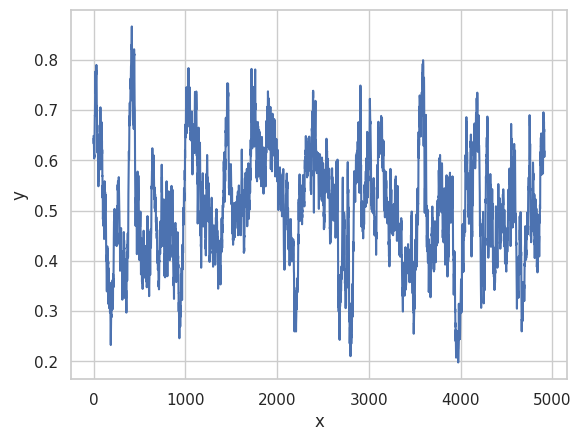

In [77]:
# Create a DataFrame
df = pd.DataFrame({'x': range(len(results_mirna)), 'y': results_mirna})
print(df.head())
# Create a relplot
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='x', y='y')

# Show the plot
plt.show()

### Test With Only Negative Sequences

In [ ]:
negative_sequence = FastaManager.read_fasta(invalid_data_path)[0][:10000]

In [ ]:
results_mirna_only_negatives = get_results_of_screening_with_word2vec(negative_sequence)

time: 2.0967650413513184 seconds


   x         y
0  0  0.417523
1  1  0.417523
2  2  0.417523
3  3  0.417523
4  4  0.417523


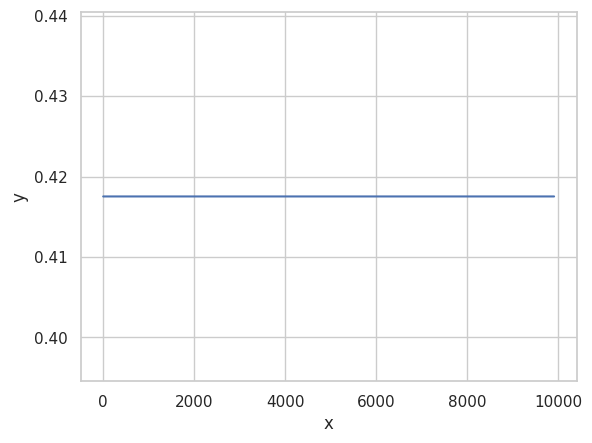

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'x': range(len(results_mirna_only_negatives)), 'y': results_mirna_only_negatives})
print(df.head())
# Create a relplot
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='x', y='y')

# Show the plot
plt.show()

# Model 1

## Train Model

In [ ]:
"""
mfe - Minimum Free Energy kcal . mol ** -1
ss  - Secondary Structure
"""

def dot_bracket_to_pairing_matrix(dot_bracket):
    L = len(dot_bracket)
    matrix = np.zeros((L, L), dtype=int)
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                matrix[i, j] = 1
                matrix[j, i] = 1

    return matrix


def one_hot_encode_sequence(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    one_hot = np.array([mapping[base] for base in sequence])
    return one_hot


def reshape_and_replicate_horizontally(one_hot):
    L, _ = one_hot.shape
    reshaped = one_hot.reshape(L, 1, 4)
    replicated = np.tile(reshaped, (1, L, 1))
    return replicated


def reshape_and_replicate_vertically(one_hot):
    L, _ = one_hot.shape
    reshaped = one_hot.reshape(1, L, 4)
    replicated = np.tile(reshaped, (L, 1, 1))
    return replicated


# seq = "AGACGACAAGGUUGAAUCGCACCCACAGUCUAUGAGUCGGUG"
# fc  = RNA.fold_compound(seq)
# (ss, mfe) = fc.mfe()

# print(f"{seq}\n{ss} ({mfe:6.2f})")


# Example sequence
sequence = "GCCCTTGGCA"
fc  = RNA.fold_compound(sequence)
(ss, mfe) = fc.mfe()
print(ss)

""" INPUT REPRESENTATION """

# One-hot encode the sequence
one_hot = one_hot_encode_sequence(sequence)

# Convert pairing matrix to L × L × 1
pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

concatenated_matrix = np.concatenate(
    (pairing_matrix_expanded,
     reshape_and_replicate_horizontally(one_hot),
     reshape_and_replicate_vertically(one_hot)), axis=2)


""" NEURAL NETWORK """


print(concatenated_matrix.shape[0])

(((...))).
10


In [ ]:
def sum_pooling(inputs):
    return tf.nn.pool(inputs, window_shape=[2, 2], pooling_type='AVG', strides=[2, 2], padding='VALID') * 4

def build_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Conv2D, ReLU, 2×2 sum-pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Lambda(sum_pooling))

    # Conv2D, ReLU, 2×2 max-pooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv2D, ReLU
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    # Downscaling to 4×4
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Reshape((1, 1, 128)))
    model.add(layers.UpSampling2D(size=(4, 4)))

    # Fully connected layer, sigmoid, output 256×1
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='sigmoid'))

    # Fully connected layer, output 2×1
    model.add(layers.Dense(2))

    # Softmax for classification
    model.add(layers.Softmax())

    return model

# Example input shape: (L, L, 9)
L = 84  # You can change L to your specific value
input_shape = (L, L, 9)
model = build_model(input_shape)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 84, 84, 32)          │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 42, 42, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_1 (Softmax)                  │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 620,034 (2.37 MB)

 Trainable params: 620,034 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# se limita la lista porque el procesador de colab no puede procesarlo en su totalidad
X_train = X_train[:20000]
X_test = X_test[:20000]
y_train = y_train[:20000]
y_test = y_test[:20000]

In [ ]:
Xtrain = []
Xtest = []
ytrain = []
ytest = []

for idx, sequence in enumerate(X_train):
  if len(sequence) != 84:
    continue
  fc  = RNA.fold_compound(sequence)
  (ss, mfe) = fc.mfe()

  """ INPUT REPRESENTATION """

  # One-hot encode the sequence
  one_hot = one_hot_encode_sequence(sequence)

  # Convert pairing matrix to L × L × 1
  pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

  concatenated_matrix = np.concatenate(
      (pairing_matrix_expanded,
      reshape_and_replicate_horizontally(one_hot),
      reshape_and_replicate_vertically(one_hot)), axis=2)

  Xtrain.append(concatenated_matrix)
  ytrain.append(y_train[idx])

for idx, sequence in enumerate(X_test):
  if len(sequence) != 84:
    continue
  fc  = RNA.fold_compound(sequence)
  (ss, mfe) = fc.mfe()

  """ INPUT REPRESENTATION """

  # One-hot encode the sequence
  one_hot = one_hot_encode_sequence(sequence)

  # Convert pairing matrix to L × L × 1
  pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

  concatenated_matrix = np.concatenate(
      (pairing_matrix_expanded,
      reshape_and_replicate_horizontally(one_hot),
      reshape_and_replicate_vertically(one_hot)), axis=2)

  Xtest.append(concatenated_matrix)
  ytest.append(y_test[idx])

In [ ]:
len(Xtest)


4

In [ ]:
# Convert lists to NumPy arrays
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)
Xtest = np.array(Xtest)
ytest = np.array(ytest)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(Xtrain, ytrain,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1250 - loss: 1.2637 - val_accuracy: 0.5000 - val_loss: 2.0717
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8750 - loss: 0.5282 - val_accuracy: 0.5000 - val_loss: 2.6204
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8750 - loss: 0.6495 - val_accuracy: 0.5000 - val_loss: 2.3841
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8750 - loss: 0.5908 - val_accuracy: 0.5000 - val_loss: 1.8586
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8750 - loss: 0.4731 - val_accuracy: 0.5000 - val_loss: 1.3112
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8750 - loss: 0.3853 - val_accuracy: 0.5000 - val_loss: 0.9595
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8750 - loss: 0.3939 - val_accuracy: 0.5000 - val_loss: 0.8519
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8750 - loss: 0.4289 - val_accuracy: 0.5000 - val_loss: 0.868

## Test Model

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(Xtest, ytest)
print(f'Test accuracy: {test_acc:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1471
Test accuracy: 1.00


In [ ]:
ypred = model.predict(Xtest)
ypred = np.argmax(ypred, axis=1)
print("Confusion Matrix:")
print(confusion_matrix(ytest, ypred))
print("\nClassification Report:")
print(classification_report(ytest, ypred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Confusion Matrix:
[[4]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



## Test Screening

In [ ]:

screen_size = SCREEN_SIZE
results = []
start = time.time()
for idx in range(0, len(random_sequence[:10000])-screen_size):
    new_sequence = random_sequence[idx:idx+screen_size]

    fc  = RNA.fold_compound(new_sequence)
    (ss, mfe) = fc.mfe()

    """ INPUT REPRESENTATION """

    # One-hot encode the sequence
    one_hot = one_hot_encode_sequence(new_sequence)

    # Convert pairing matrix to L × L × 1
    pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

    concatenated_matrix = np.concatenate(
        (pairing_matrix_expanded,
        reshape_and_replicate_horizontally(one_hot),
        reshape_and_replicate_vertically(one_hot)), axis=2)

    new_prediction = model.predict(np.expand_dims(concatenated_matrix, axis=0))
    results.append(new_prediction)
end = time.time()
print(f"time: {end-start} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
results

NameError: name 'results' is not defined

In [ ]:
results_model1 = [res[0][1] for res in results]
print(results_model1)

NameError: name 'results' is not defined

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'x': range(len(results_model1)), 'y': results_model1})
print(df.head())
# Create a relplot
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='x', y='y')

# Show the plot
plt.show()

In [ ]:
# añadir correlación de ambas gráficas
R2 = np.corrcoef(results_mirna, results_model1)
print(R2)

existe una asociación entre ambos modelos

### Test With Only Negative Sequences

In [ ]:
screen_size = SCREEN_SIZE
results_model1_only_negatives = []
start = time.time()
for idx in range(0, len(sequence_for_screening_only_negatives[:10000])-screen_size):
    new_sequence = sequence_for_screening_only_negatives[idx:idx+screen_size]
    new_embedding = miRNA2Vec.get_average_embeddings([new_sequence])
    new_prediction = svm_model.predict_proba(new_embedding)
    results_model1_only_negatives.append(new_prediction[0][1])
end = time.time()
print(f"time: {end-start} seconds")

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'x': range(len(results_model1_only_negatives)), 'y': results_model1_only_negatives})
print(df.head())
# Create a relplot
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='x', y='y')

# Show the plot
plt.show()

In [ ]:
# separar data solo para el screening, ya que se están evaluando las mismas secuencias del training y testing                               DONE

# implementar caso donde no haya micro RNA, solo muestras negativas                                                                         DONE

# sequence_for_screening -> convertir secuencia a ADN (U -> T)                                                                              DONE

# probar con algún cromosoma de base de datos - buscar locus de algun pre microRNA, cortar un trecho grande que rodee a ese pre-miRNA

# probar partiendo desde los extremos (dos casos)

# alto FP, porque los pseudoRNA fueron escogidos para tener caracteristicas muy parecidas al miRNA

# buscar base de datos para importar zonas genómicas (ensemble, etc)

# https://www.ensembl.org/Homo_sapiens/Location/Chromosome?r=1

# 100 casos de test

# https://www.ncbi.nlm.nih.gov/gdv/browser/genome/?id=GCF_000001405.40


In [ ]:
# 1. metricas podrian mejorar al usar cromosoma real en lugar de pseudo hairpins, ya que fueron construido para ser próximos a las muestras positivas ( comprobar hipotesis )


# [DONE] 2. en lugar de concatenar, generar aleatoriamente y luego agregar los casos positivos dentro de la secuencia.     (basado en las proporciones de los nucleotidos)
    # obtener histograma de A,C,G,U de la secuencia generada
    # sacar secuencia aleatoria con distribucion obtenida en el punto previo


# 3. para la siguiente prueba, utilizar una secuencia real


# [DONE] 4. realizar tunning con hiperparámetros del modelo word 2 vec (considerar otra arquitectura, basada en embedding)
    # tunear kmres, epochs con valores mayores


# 5. considerar mejorar el clasificador con red neuronal o random forest
    # probar primero con RANDOM FOREST !
    # red neuronal dejar para después


# considerar ensamble de embedding con distintos k_mers (revisar en la literatura)


In [ ]:
analisis de sensibilidad a la cantidad de datos

1. probar tunning con 100 muestras
2. probar con 200

observar si aumenta desempeño - AUMENTA


In [ ]:
coger los casos positivos y hacer shuffle de sus caracteres. Ejm: hola != ahol

coger trechos aleatorios de adn que no sean mirna.

invertir los nucleotidos que se complementan. Generan pequeñas perturbaciones, como el reversion.
obtener nuevas secuencias por complementariedad.

ATTCGGCATCGT
TAAGCCGTAGCA

In [ ]:
revisar como generaron los casos negativos en la tesis doctoral

This figure shows the
structural similarities between the predicted secondary structure of the Bombyx mori pre-miRNA
bmo-mir-2855 and a pseudo hairpin taken from Bombyx mori protein coding sequences (cds)
[14].

A total of 8,494 pseudo hairpins were extracted from human protein coding sequences (CDS),
where no known splice event had been reported [95].

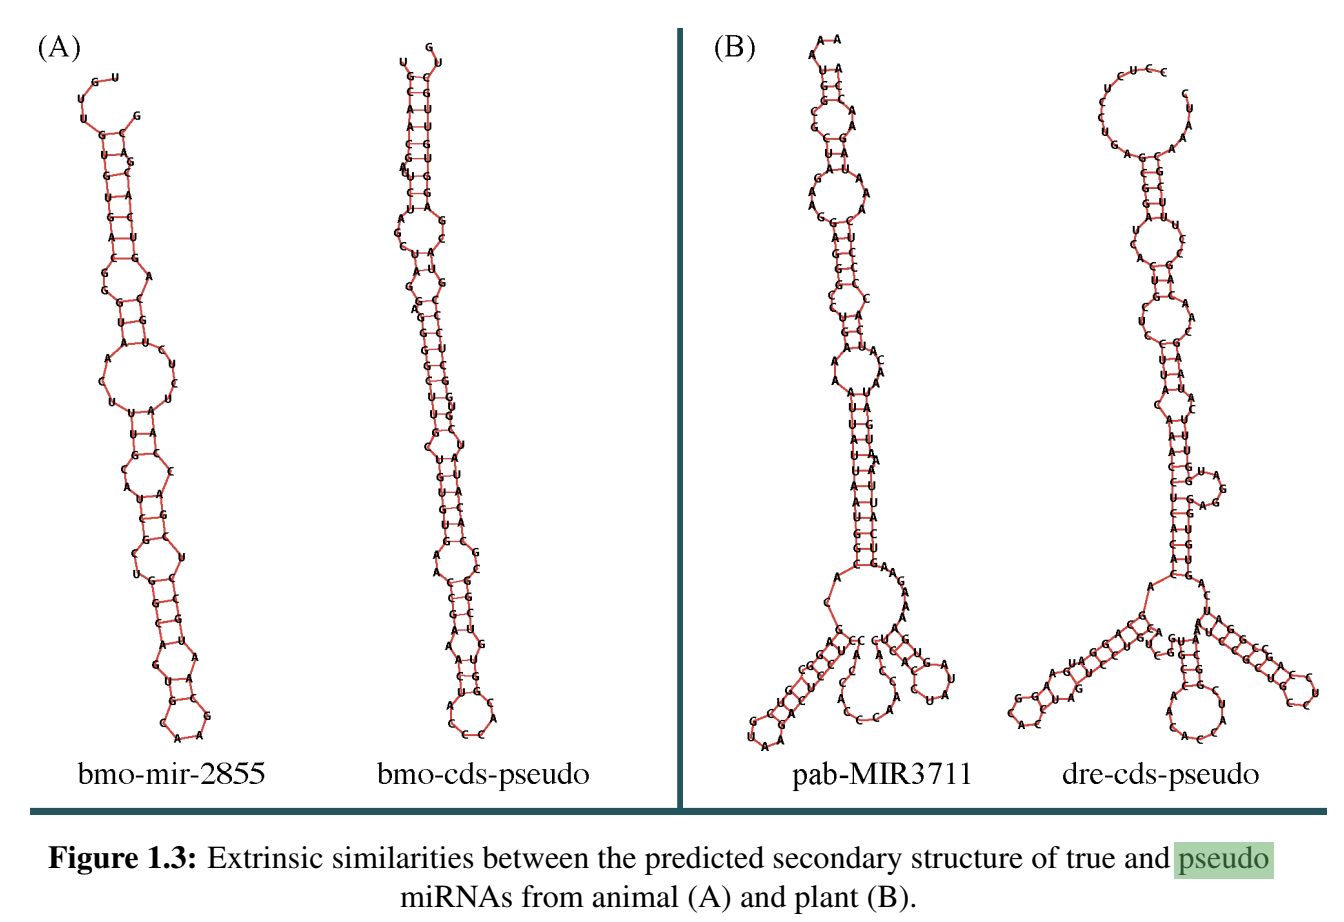

revisar cuanto aporta la data aumentada a las metricas del test model.


# Model 2

1. registrar como varia metricas con distintos negativos.
    1.1. solo ivani
    1.2. ivani / ensemble
    1.3. solo ensemble
    quiero saber si el modelo tiene capacidad de aprender patrones complejos
    prueba de overfitting
2. crear repo github y compartir a asesor
3. el tunning debe estar pensado en el clasificador que se piensa utilizar.
4. utilizar clasificadores que aprendan mejor
5. Para LSTM, utilizar cada triplete, mas no el promedio.
6. por cada triplete, se encodea y pasa a LSTM hasta la ultima... definir tamaño máximo -> llenar con ceros los tokens que falten
7. revisar si hay stopwords en libreria sobre LSTM, sino solo queda llenar con 0s (valores aleatorios)
